In [1]:
import numpy as np
import matplotlib.pyplot as plt
np.set_printoptions(suppress=True)
np.set_printoptions(threshold=10, edgeitems=4)

In [2]:
tile_size = 1024
overlap = 128
y_drop = 250
threshold = 4000

random_pattern = True
# number of PEs compute in the same time
num_PE = 64

In [3]:
# W = {'A': {'A':  91, 'C': -90, 'G': -25, 'T':-100},
#      'C': {'A': -90, 'C': 100, 'G':-100, 'T': -25},
#      'G': {'A': -25, 'C':-100, 'G': 100, 'T': -90},
#      'T': {'A':-100, 'C': -25, 'G': -90, 'T':  91}}
# g_o = -430
# g_e = -30

W = {'A': {'A': 3, 'C':-3, 'G':-1, 'T':-4},
     'C': {'A':-3, 'C': 4, 'G':-4, 'T':-1},
     'G': {'A':-1, 'C':-4, 'G': 4, 'T':-3},
     'T': {'A':-4, 'C':-1, 'G':-3, 'T': 3}}
g_o = -12
g_e = -1

In [4]:
# W = {'A': {'A': 2, 'C':-3, 'G':-3, 'T':-3},
#      'C': {'A':-3, 'C': 2, 'G':-3, 'T':-3},
#      'G': {'A':-3, 'C':-3, 'G': 2, 'T':-3},
#      'T': {'A':-3, 'C':-3, 'G':-3, 'T': 2}}
# g_o = -7
# g_e = -2

In [5]:
# f = open('sequence_1.txt', 'r')
# gene_1 = ''
# f.readline()
# for line in f.readlines():
#     gene_1 = gene_1 + line[:-1]
# f.close()

# f = open('sequence_2.txt', 'r')
# gene_2 = ''
# f.readline()
# for line in f.readlines():
#     gene_2 = gene_2 + line[:-1]
# f.close()

# print(len(gene_1), len(gene_2))

In [6]:
# bias = 0
# gene_1, gene_2 = gene_1[bias:bias+tile_size], gene_2[bias:bias+tile_size]
# print(len(gene_1), len(gene_2))
# print(gene_1)
# print(gene_2)

In [7]:
import random
seed = 3
prob = (6 + seed)/100
random.seed(seed)

d = ['A', 'C', 'G', 'T']
if random_pattern:
    gene_1, gene_2 = '', ''
    for i in range(tile_size):
        gene_1 += d[random.randint(0, 3)]
    i = 0
    while i < tile_size:
        die = random.random()
        l = random.randint(1,8)
        # delete gene_1 for length l
        if die < prob:
            i += l
        # insert gene_1 for length l
        elif die < 2*prob:
            for j in range(l):
                gene_2 += d[random.randint(0, 3)]
            i += 1
        # change 1 gene
        elif die < 3*prob:
            gene_2 += d[random.randint(0, 3)]
            i += 1
        else:
            gene_2 += gene_1[i]
            i += 1
    while len(gene_2) < tile_size:
        gene_2 += d[random.randint(0, 3)]
            
    print(len(gene_1), len(gene_2))
    print(gene_1)
    print(gene_2)

1024 1024
CCGTAATGCCTTTCCCTAACAGAGTTTTTCGAACTCGTGTTGTCGAGCGACGGAATTAGATCAGTTAAATGGCAGAAAACTGGCAGGGCTTTTAGTCGTGGGATGATCAGTGGGTAAAGGTGGCGCGGGGTAACGCGCGCTAAGGCTCAGCTGCAACGCGGAGCTGGTGTGTTATCCATTCATGGCAGACAACTAATACGCATAAGCGTAGCCAACCGCATTAGCGTATGAACAAAATAATGCGAGTTGGGCGTACATACAGTTATAGTGTTTACCGATCTCAGGGATATAGAATCCTAAATCAGAAATGGAACAAAGCACCCTTGGTGTATCTCTTCTCCATTTCCGCCGCGTGCGAGTTCCGCGTCTTCTATATATCCACGCCGCCAGCAGCTAAAAGGAGTGAAGGTTTACTTCGAGATATGAGGTGGAGATGAGCCCGTAACGTGCTTGCAACTGAGGTACATGCGGTTAGTACGAAACCTTCCTCCCCGGGATTTGGTGTACAACTCTCCCATAGCCTAAAGCATAGGGGCAAAGCACTCTGAATACCTTTATCTGATTTTCTAGGGTGTCACGGCTCCCACTCACACTTCAATTGTAACTATTACCATTCCGAGAAGGTGTCGAGGGAATAAAAAACATACGCTGTGATGTAGCTATGTCTGCGTTCTTGGCTTACCATAAGCAATTGGAACTAGGATACCACCAACGCCTGCTCAAAAACGAATTCATGTTAGTTCAATGAGGCTAGTACCGAGCTTAGCGCCCTTGCTTTTAGACAACGATACCGTTAGTCGCATGTTACCTGTGCTGTTCGGGATGGGCAACCACAACTGGATCCAGTGAATGGCTTGGAATACCCTGCGACAATATTTGCGCACATGTTGGTGCGCATTCTGAGATCGGATAGATTCGGCTTGAGCAGGTGACTGTATCCAAAAGATGTTGGACCTCCCCTTACTACCGCCCACCTATTCAGACACGCTG

In [8]:
# tile_size = 52
# gene_1 = gene_1[:tile_size]
# gene_2 = gene_2[:tile_size]
# print(gene_1)
# print(gene_2)

# Normal version

In [9]:
# Score matrix
V = np.zeros((tile_size+1, tile_size+1))
I = np.zeros((tile_size+1, tile_size+1))
D = np.zeros((tile_size+1, tile_size+1))
for i in range(1, tile_size+1):
    V[0, i] = g_o + (i-1)*g_e
    V[i, 0] = g_o + (i-1)*g_e
    D[0, i] = float('-inf')
    D[i, 0] = g_o + (i-1)*g_e
    I[0, i] = g_o + (i-1)*g_e
    I[i, 0] = float('-inf')
print('Score matrix')
print(V)
print('Insertion matrix (Score when direction is left)')
print(I)
print('Deletion matrix (Score when direction is top)')
print(D)
# Direction matrix, 0:no compute, 1:top-left, 2:top, 3:left
Trace = np.zeros((tile_size+1, tile_size+1), dtype=int)
# When direction = 'left' or 'top', we needs to trace next direction on 'Trace_I' or 'Trace_D' instead of 'Trace'
# 0:from Trace_I or Trace_D (extend gap), 1:from Trace (new gap)
Trace_I = np.zeros((tile_size+1, tile_size+1), dtype=int)
Trace_D = np.zeros((tile_size+1, tile_size+1), dtype=int)

Score matrix
[[    0.   -12.   -13.   -14. ... -1032. -1033. -1034. -1035.]
 [  -12.     0.     0.     0. ...     0.     0.     0.     0.]
 [  -13.     0.     0.     0. ...     0.     0.     0.     0.]
 [  -14.     0.     0.     0. ...     0.     0.     0.     0.]
 ...
 [-1032.     0.     0.     0. ...     0.     0.     0.     0.]
 [-1033.     0.     0.     0. ...     0.     0.     0.     0.]
 [-1034.     0.     0.     0. ...     0.     0.     0.     0.]
 [-1035.     0.     0.     0. ...     0.     0.     0.     0.]]
Insertion matrix (Score when direction is left)
[[    0.   -12.   -13.   -14. ... -1032. -1033. -1034. -1035.]
 [  -inf     0.     0.     0. ...     0.     0.     0.     0.]
 [  -inf     0.     0.     0. ...     0.     0.     0.     0.]
 [  -inf     0.     0.     0. ...     0.     0.     0.     0.]
 ...
 [  -inf     0.     0.     0. ...     0.     0.     0.     0.]
 [  -inf     0.     0.     0. ...     0.     0.     0.     0.]
 [  -inf     0.     0.     0. ...     0.     0

In [10]:
V_max = float('-inf')
x_max, y_max = 0, 0
i,j = 1,1
print(V[i-1][j-1] + W[gene_1[i-1]][gene_2[j-1]])
print(V[i][j-1]+g_o, I[i][j-1]+g_e)
print(V[i-1][j]+g_o, D[i-1][j]+g_e)

for i in range(1, tile_size+1):
    for j in range(1, tile_size+1):
        V_nxt = V[i-1][j-1] + W[gene_1[i-1]][gene_2[j-1]]
        I[i][j] = max(V[i][j-1]+g_o, I[i][j-1]+g_e)
        D[i][j] = max(V[i-1][j]+g_o, D[i-1][j]+g_e)
        V[i][j] = max(V_nxt, I[i][j], D[i][j])
        # if new maximum
        if V[i][j] >= V_max:
            V_max = V[i][j]
            x_max, y_max = i, j
        # direction of Trace
        if V[i][j] == V_nxt:
            Trace[i][j] = 1
        elif V[i][j] == D[i][j]:
            Trace[i][j] = 2
        elif V[i][j] == I[i][j]:
            Trace[i][j] = 3
        # direction of Trace_I
        if I[i][j] == V[i][j-1]+g_o:
            Trace_I[i][j] = 1
        else:
            Trace_I[i][j] = 0
        # direction of Trace_D
        if D[i][j] == V[i-1][j]+g_o:
            Trace_D[i][j] = 1
        else:
            Trace_D[i][j] = 0
    # print(V_max)
print('Score matrix')
print(V)
print('Insertion matrix (Score when direction is left)')
print(I)
print('Deletion matrix (Score when direction is top)')
print(D)
print('Direction')
print(Trace)
print('Direction of I')
print(Trace_D)
print('Direction of D')
print(Trace_I)
print(V_max, x_max, y_max)

4.0
-24.0 -inf
-24.0 -inf
Score matrix
[[    0.   -12.   -13.   -14. ... -1032. -1033. -1034. -1035.]
 [  -12.     4.    -8.    -9. ... -1027. -1028. -1029. -1030.]
 [  -13.    -8.     8.    -4. ... -1022. -1023. -1024. -1025.]
 [  -14.    -9.    -4.    12. ... -1017. -1018. -1019. -1020.]
 ...
 [-1032. -1027. -1022. -1017. ...   687.   702.   690.   689.]
 [-1033. -1028. -1023. -1018. ...   691.   691.   698.   689.]
 [-1034. -1029. -1024. -1019. ...   691.   689.   690.   694.]
 [-1035. -1030. -1025. -1020. ...   693.   692.   691.   690.]]
Insertion matrix (Score when direction is left)
[[    0.   -12.   -13.   -14. ... -1032. -1033. -1034. -1035.]
 [  -inf   -24.    -8.    -9. ... -1027. -1028. -1029. -1030.]
 [  -inf   -25.   -20.    -4. ... -1022. -1023. -1024. -1025.]
 [  -inf   -26.   -21.   -16. ... -1017. -1018. -1019. -1020.]
 ...
 [  -inf -1044. -1039. -1034. ...   686.   685.   690.   689.]
 [  -inf -1045. -1040. -1035. ...   691.   690.   689.   688.]
 [  -inf -1046. -104

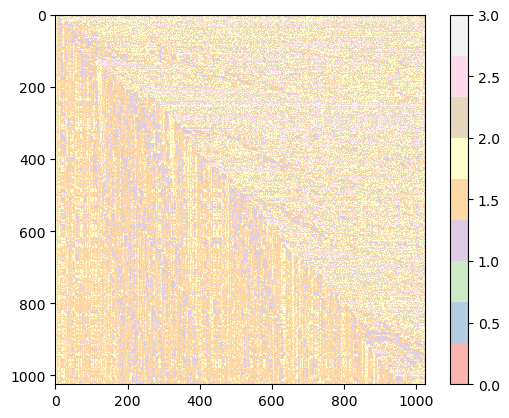

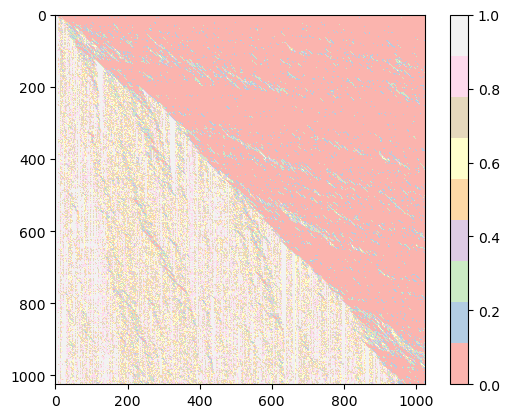

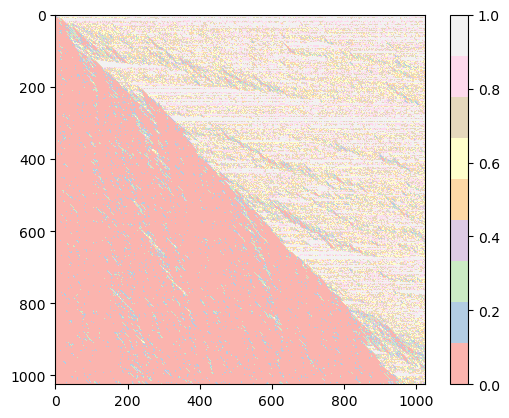

In [11]:
Trace_ans = Trace
Trace_I_ans = Trace_I
Trace_D_ans = Trace_D
plt.imshow(Trace[:, :], cmap='Pastel1')
plt.colorbar()
plt.show()
plt.imshow(Trace_I[:, :], cmap='Pastel1')
plt.colorbar()
plt.show()
plt.imshow(Trace_D[:, :], cmap='Pastel1')
plt.colorbar()
plt.show()

Score: 759.0, Position: (999, 941)


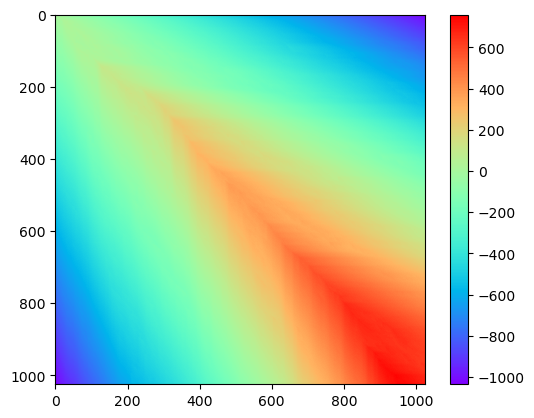

In [12]:
V_ans = V
print(f'Score: {V_max}, Position: {x_max, y_max}')
plt.imshow(V[:, :], cmap='rainbow')
plt.colorbar()
plt.show()

In [13]:
seq_1 = ''
seq_2 = ''
result = ''
# which matirx are we tracking now
target_matrix = 'T'

x, y = x_max, y_max
while(x != 0) and (y != 0):
    if target_matrix == 'T':
        # print('T', Trace[x][y], x, y)
        if Trace[x][y] == 1:
            seq_1 = gene_1[x-1] + seq_1
            seq_2 = gene_2[y-1] + seq_2
            if gene_1[x-1] == gene_2[y-1]:
                result = '|' + result
            else:
                result = ' ' + result
            x, y = x-1, y-1
        # if direction = top, move to Trace_D
        elif Trace[x][y] == 2:
            if Trace_D[x][y] == 0:
                target_matrix = 'D'
            seq_1 = gene_1[x-1] + seq_1
            seq_2 = '-' + seq_2
            result = ' ' + result
            x, y = x-1, y
        # if direction = left, move to Trace_I
        elif Trace[x][y] == 3:
            if Trace_I[x][y] == 0:
                target_matrix = 'I'
            seq_1 = '-' + seq_1
            seq_2 = gene_2[y-1] + seq_2
            result = ' ' + result
            x, y = x, y-1
    elif target_matrix == 'D':
        # print('D', Trace_D[x][y], x, y)
        # move to Trace if reach gap origin
        if Trace_D[x][y] == 1:
            target_matrix = 'T'
        seq_1 = gene_1[x-1] + seq_1
        seq_2 = '-' + seq_2
        result = ' ' + result
        x, y = x-1, y
    elif target_matrix == 'I':
        # print('I', Trace_I[x][y], x, y)
        # move to Trace if reach gap origin
        if Trace_I[x][y] == 1:
            target_matrix = 'T'
        seq_1 = '-' + seq_1
        seq_2 = gene_2[y-1] + seq_2
        result = ' ' + result
        x, y = x, y-1

width = 60
parts = len(seq_1)//width + 1
print(f'Score: {V_max}, Position: {x_max, y_max}')
for i in range(parts):
    print(seq_1[i*width:min(i*width+width, len(seq_1))])
    print(result[i*width:min(i*width+width, len(result))])
    print(seq_2[i*width:min(i*width+width, len(seq_2))])
    print('')

seq_1_ans = seq_1
seq_2_ans = seq_2
result_ans = result

Score: 759.0, Position: (999, 941)
CCGTA-------ATGCCTTTCCCTAACAGAGTTTTTCGAACTCGTGTTGTCGAGCGACGG
|||||        ||||||||||| ||                      ||| |      
CCGTAGCCGTGGGTGCCTTTCCCTTAC----------------------TCGGG------

AATTAGATCAGTTAAATGGCAGAAAA--------------CTGGCAGGGCTTTTAGTCGT
      |||  |||| |   ||||||              | ||  ||  |   |||| |
-----AATCGATTAAGT-ATAGAAAACGCTTTTGTTGGTCCGGGTGGGATTCGCAGTCTT

GGGATGATCAGTGGGTAAAGGTGGCGCGGGGTAACGCGCGCTAAGG--------------
||   |    |||   ||||  ||||||||||||||||||||||||              
GGTGCGTCTCGTG---AAAGTGGGCGCGGGGTAACGCGCGCTAAGGTCTGAATTCTGGCA

--------CTCAGC----------TGCAACGCGGAGCTGGTGTGTTATCCAT-TCATGGC
        || |||           |||  ||| | ||      |||| ||| | | | |
TCGACGCACTGAGCGTTTTGCTCGCGCATTGCGCAACTTAACGATTATGCATATGACGAC

AGACAAC--------------TAATACGCA---TAAGCGTAGCCAACCGCATTA--GCGT
 |||| |              |||||||||   |||||||||||||| ||||||   |||
TGACAGCTCGCCAATCTAAATTAATACGCACACTAAGCGTAGCCAACGGCATTATGTCGT

ATG---AACAAAATA---ATGCGAGTTGGGCGTACATACAGTTAT

In [14]:
# checking calculation
score = 0
for i in range(len(seq_1)):
    if seq_1[i] == '-':
        if seq_1[i-1] == '-':
            score += g_e
        else:
            score += g_o
    elif seq_2[i] == '-':
        if seq_2[i-1] == '-':
            score += g_e
        else:
            score += g_o
    else:
        score += W[seq_1[i]][seq_2[i]]
print(score)

759


# With stripe (No banded)

In [15]:
# Score matrix
V = np.zeros((tile_size+1, tile_size+1))
V = V + float('-inf')
V[0][0] = 0
I = np.zeros((tile_size+1, tile_size+1))
D = np.zeros((tile_size+1, tile_size+1))
for i in range(1, tile_size+1):
    V[0, i] = g_o + (i-1)*g_e
    V[i, 0] = g_o + (i-1)*g_e
    D[0, i] = float('-inf')
    D[i, 0] = g_o + (i-1)*g_e
    I[0, i] = g_o + (i-1)*g_e
    I[i, 0] = float('-inf')
print('Score matrix')
print(V)
print('Insertion matrix (Score when direction is left)')
print(I)
print('Deletion matrix (Score when direction is top)')
print(D)
# Direction matrix, 0:no compute, 1:top-left, 2:top, 3:left
Trace = np.zeros((tile_size+1, tile_size+1), dtype=int)
# When direction = 'left' or 'top', we needs to trace next direction on 'Trace_I' or 'Trace_D' instead of 'Trace'
# 0:from Trace_I or Trace_D (extend gap), 1:from Trace (new gap)
Trace_I = np.zeros((tile_size+1, tile_size+1), dtype=int)
Trace_D = np.zeros((tile_size+1, tile_size+1), dtype=int)

Score matrix
[[    0.   -12.   -13.   -14. ... -1032. -1033. -1034. -1035.]
 [  -12.   -inf   -inf   -inf ...   -inf   -inf   -inf   -inf]
 [  -13.   -inf   -inf   -inf ...   -inf   -inf   -inf   -inf]
 [  -14.   -inf   -inf   -inf ...   -inf   -inf   -inf   -inf]
 ...
 [-1032.   -inf   -inf   -inf ...   -inf   -inf   -inf   -inf]
 [-1033.   -inf   -inf   -inf ...   -inf   -inf   -inf   -inf]
 [-1034.   -inf   -inf   -inf ...   -inf   -inf   -inf   -inf]
 [-1035.   -inf   -inf   -inf ...   -inf   -inf   -inf   -inf]]
Insertion matrix (Score when direction is left)
[[    0.   -12.   -13.   -14. ... -1032. -1033. -1034. -1035.]
 [  -inf     0.     0.     0. ...     0.     0.     0.     0.]
 [  -inf     0.     0.     0. ...     0.     0.     0.     0.]
 [  -inf     0.     0.     0. ...     0.     0.     0.     0.]
 ...
 [  -inf     0.     0.     0. ...     0.     0.     0.     0.]
 [  -inf     0.     0.     0. ...     0.     0.     0.     0.]
 [  -inf     0.     0.     0. ...     0.     0

In [16]:
# start position of next PE stripe
column_start_nxt = 1
V_max = 0
x_max, y_max = 0, 0
# 4 PEs compute in the same time
for i in range(1, tile_size+1, 4):
    column_start_nxt_determined = False
    # column = column_start_nxt # current row
    column = 1
    stripe_end = False
    while not stripe_end:
        # row index: i+j, column index:column
        for j in range(4):
            # print(i+j, column)
            V_nxt = V[i+j-1][column-1] + W[gene_1[i+j-1]][gene_2[column-1]]
            I[i+j][column] = max(V[i+j][column-1]+g_o, I[i+j][column-1]+g_e)
            D[i+j][column] = max(V[i+j-1][column]+g_o, D[i+j-1][column]+g_e)
            V[i+j][column] = max(V_nxt, I[i+j][column], D[i+j][column])
            # print(i+j, column, V[i+j][column])
            # track max score
            if V[i+j][column] >= V_max:
                V_max = V[i+j][column]
                x_max, y_max = i+j, column
            # track direction
            if V[i+j][column] == V_nxt:
                Trace[i+j][column] = 1
            elif V[i+j][column] == D[i+j][column]:
                Trace[i+j][column] = 2
            elif V[i+j][column] == I[i+j][column]:
                Trace[i+j][column] = 3
            # direction of Trace_I
            if I[i+j][column] == V[i+j][column-1]+g_o:
                Trace_I[i+j][column] = 1
            else:
                Trace_I[i+j][column] = 0
            # direction of Trace_D
            if D[i+j][column] == V[i+j-1][column]+g_o:
                Trace_D[i+j][column] = 1
            else:
                Trace_D[i+j][column] = 0
            
        # if stripe end
        if column == tile_size:
            stripe_end = True
        '''
        elif (V[i][column]<V_max-y_drop) & (V[i+1][column]<V_max-y_drop) & (V[i+2][column]<V_max-y_drop) & (V[i+3][column]<V_max-y_drop):
            stripe_end = True
        '''
        # next stripe start position
        if not column_start_nxt_determined:
            if (V[i][column]>V_max-y_drop) & (V[i+1][column]>V_max-y_drop) & (V[i+2][column]>V_max-y_drop) & (V[i+3][column]>V_max-y_drop):
                column_start_nxt = column
                column_start_nxt_determined =True
        # PE shift to next column
        column += 1

print('Score matrix')
print(V)
print('Insertion matrix (Score when direction is left)')
print(I)
print('Deletion matrix (Score when direction is top)')
print(D)
print('Direction')
print(Trace)
print(V_max, x_max, y_max)

Score matrix
[[    0.   -12.   -13.   -14. ... -1032. -1033. -1034. -1035.]
 [  -12.     4.    -8.    -9. ... -1027. -1028. -1029. -1030.]
 [  -13.    -8.     8.    -4. ... -1022. -1023. -1024. -1025.]
 [  -14.    -9.    -4.    12. ... -1017. -1018. -1019. -1020.]
 ...
 [-1032. -1027. -1022. -1017. ...   687.   702.   690.   689.]
 [-1033. -1028. -1023. -1018. ...   691.   691.   698.   689.]
 [-1034. -1029. -1024. -1019. ...   691.   689.   690.   694.]
 [-1035. -1030. -1025. -1020. ...   693.   692.   691.   690.]]
Insertion matrix (Score when direction is left)
[[    0.   -12.   -13.   -14. ... -1032. -1033. -1034. -1035.]
 [  -inf   -24.    -8.    -9. ... -1027. -1028. -1029. -1030.]
 [  -inf   -25.   -20.    -4. ... -1022. -1023. -1024. -1025.]
 [  -inf   -26.   -21.   -16. ... -1017. -1018. -1019. -1020.]
 ...
 [  -inf -1044. -1039. -1034. ...   686.   685.   690.   689.]
 [  -inf -1045. -1040. -1035. ...   691.   690.   689.   688.]
 [  -inf -1046. -1041. -1036. ...   689.   688

In [17]:
print(Trace_ans.all() == Trace.all())
print(Trace_I_ans.all() == Trace_I.all())
print(Trace_D_ans.all() == Trace_D.all())
print(V_ans.all() == V.all())

True
True
True
True


999 941


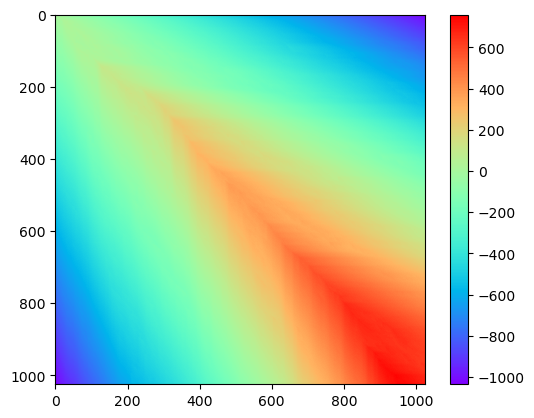

In [18]:
print(x_max, y_max)
plt.imshow(V[:, :], cmap='rainbow')
plt.colorbar()
plt.show()

# With stripe (banded)

In [19]:
# Score matrix
V = np.zeros((tile_size+1, tile_size+1))
V = V + float('-inf')
V[0][0] = 0
I = np.zeros((tile_size+1, tile_size+1))
I = I + float('-inf')
I[0][0] = 0
D = np.zeros((tile_size+1, tile_size+1))
D = D + float('-inf')
D[0][0] = 0

for i in range(1, tile_size+1):
    V[0, i] = g_o + (i-1)*g_e
    V[i, 0] = g_o + (i-1)*g_e
#     V[0, i] = float('-inf')
#     V[i, 0] = float('-inf')
    D[0, i] = float('-inf')
    D[i, 0] = g_o + i*g_e
    I[0, i] = g_o + i*g_e
#     D[i, 0] = float('-inf')
#     I[0, i] = float('-inf')
    I[i, 0] = float('-inf')
print('Score matrix')
print(V)
print('Insertion matrix (Score when direction is left)')
print(I)
print('Deletion matrix (Score when direction is top)')
print(D)
# Direction matrix, 0:no compute, 1:top-left, 2:top, 3:left
Trace = np.zeros((tile_size+1, tile_size+1), dtype=int)
Trace_2x = np.zeros((tile_size+1, tile_size+1), dtype=int)
# When direction = 'left' or 'top', we needs to trace next direction on 'Trace_I' or 'Trace_D' instead of 'Trace'
# 0:from Trace_I or Trace_D (extend gap), 1:from Trace (new gap)
Trace_I = np.zeros((tile_size+1, tile_size+1), dtype=int)
Trace_D = np.zeros((tile_size+1, tile_size+1), dtype=int)

Score matrix
[[    0.   -12.   -13.   -14. ... -1032. -1033. -1034. -1035.]
 [  -12.   -inf   -inf   -inf ...   -inf   -inf   -inf   -inf]
 [  -13.   -inf   -inf   -inf ...   -inf   -inf   -inf   -inf]
 [  -14.   -inf   -inf   -inf ...   -inf   -inf   -inf   -inf]
 ...
 [-1032.   -inf   -inf   -inf ...   -inf   -inf   -inf   -inf]
 [-1033.   -inf   -inf   -inf ...   -inf   -inf   -inf   -inf]
 [-1034.   -inf   -inf   -inf ...   -inf   -inf   -inf   -inf]
 [-1035.   -inf   -inf   -inf ...   -inf   -inf   -inf   -inf]]
Insertion matrix (Score when direction is left)
[[    0.   -13.   -14.   -15. ... -1033. -1034. -1035. -1036.]
 [  -inf   -inf   -inf   -inf ...   -inf   -inf   -inf   -inf]
 [  -inf   -inf   -inf   -inf ...   -inf   -inf   -inf   -inf]
 [  -inf   -inf   -inf   -inf ...   -inf   -inf   -inf   -inf]
 ...
 [  -inf   -inf   -inf   -inf ...   -inf   -inf   -inf   -inf]
 [  -inf   -inf   -inf   -inf ...   -inf   -inf   -inf   -inf]
 [  -inf   -inf   -inf   -inf ...   -inf   -in

In [20]:
path = 'output_score.txt'
f = open(path, 'w')

# start position of next PE stripe
column_start = 1
column_end = 1
V_max = 0
V_max_local = 0
x_max, y_max = 0, 0
x_max_local, y_max_local = 0, 0

for i in range(1, tile_size+1, num_PE):
    column = column_start # current row
    V_max_local = 0
    stripe_len = 0
    # print(f"{(i+3)//4}'th stripe start at column {column}")
    stripe_end = False
    # save min scores of 64 PEs in every position
    min_scores = []
    f.write(f'stripe {i//64} \n')
    while not stripe_end:
        # row index: i+j, column index:column
        # save scores of 64 PEs
        scores = []
        for j in range(num_PE):
            if i+j > tile_size:
                break
            # print(j, column)
            # anti-diagonal PE
            column_shift = column - j
            # PEs out of bound
            if (column_shift < column_start) or (column_shift > tile_size):
                # print('skip', column_shift, j)
                scores.append(-1000000)
                continue
                
            V_nxt = V[i+j-1][column_shift-1] + W[gene_1[i+j-1]][gene_2[column_shift-1]]
            I[i+j][column_shift] = max(V[i+j][column_shift-1]+g_o, I[i+j][column_shift-1]+g_e)
            D[i+j][column_shift] = max(V[i+j-1][column_shift]+g_o, D[i+j-1][column_shift]+g_e)
            V[i+j][column_shift] = max(V_nxt, I[i+j][column_shift], D[i+j][column_shift])
            scores.append(V[i+j][column_shift])
            # track max score
            if V[i+j][column_shift] >= V_max:
                V_max = V[i+j][column_shift]
                x_max, y_max = i+j, column_shift
            # local minimum for stripe end
            if V[i+j][column_shift] > V_max_local:
                V_max_local = V[i+j][column_shift]
                x_max_local, y_max_local = i+j, column_shift
            # track direction
            if V[i+j][column_shift] == V_nxt:
                Trace[i+j][column_shift] = 1
                # 2 step diagonal
                if ((Trace_2x[i+j-1][column_shift-1] == 1) or (Trace_2x[i+j-1][column_shift-1] == 4)) and ((i+j-1) % 64 > 0):
                    Trace_2x[i+j][column_shift] = 4
                else:
                    Trace_2x[i+j][column_shift] = 1
            elif V[i+j][column_shift] == D[i+j][column_shift]:
                Trace[i+j][column_shift] = 2
                Trace_2x[i+j][column_shift] = 2
            elif V[i+j][column_shift] == I[i+j][column_shift]:
                Trace[i+j][column_shift] = 3
                Trace_2x[i+j][column_shift] = 3
            # direction of Trace_I
            if I[i+j][column_shift] == V[i+j][column_shift-1]+g_o:
                Trace_I[i+j][column_shift] = 1
            else:
                Trace_I[i+j][column_shift] = 0
            # direction of Trace_D
            if D[i+j][column_shift] == V[i+j-1][column_shift]+g_o:
                Trace_D[i+j][column_shift] = 1
            else:
                Trace_D[i+j][column_shift] = 0
        # if stripe end
        # working number of PEs amy < total number when last stripe
        max_in_PEs = max(scores)
        min_scores.append(min(scores))
        f.writelines(str(scores))
        f.write(' max ')
        f.write(str(max_in_PEs))
        f.write(' mins ')
        f.write(str(min(scores)))
        f.write('\n')
        # print(max_in_PEs, V_max, V_max-y_drop)
        # needs to end far than max_y
        if (max_in_PEs < V_max_local-y_drop) or (max_in_PEs == -1000000) or (stripe_len == 511):
            stripe_end = True
            column_end = column
            print(f"{i//64}'th stripe ended at column {column}")
        # PE shift to next column
        column += 1
        stripe_len += 1
    # next stripe start position
    early_end = True
    # print('threshold:', V_max_local-y_drop, V_max_local, y_drop)
    for m in range(63, len(min_scores)):
        # print(min_scores[m], V_max_local-y_drop)
        if min_scores[m] > V_max_local-y_drop:
            column_start += m-63
            early_end = False
            break
    print('max:', V_max, 'local max:', V_max_local, 'next column start:', column_start)
    print('')
    # all score in stripe < maximum
    if early_end:
        print('early stop')
        column_start += 32
print('Score matrix')
print(V)
print('Insertion matrix (Score when direction is left)')
print(I)
print('Deletion matrix (Score when direction is top)')
print(D)
print('Direction')
print(Trace)
print(V_max, x_max, y_max)
f.close()

0'th stripe ended at column 412
max: 41.0 local max: 41.0 next column start: 1

1'th stripe ended at column 509
max: 56.0 local max: 56.0 next column start: 1

2'th stripe ended at column 511
max: 130.0 local max: 130.0 next column start: 41

3'th stripe ended at column 552
max: 204.0 local max: 204.0 next column start: 110

4'th stripe ended at column 621
max: 269.0 local max: 269.0 next column start: 196

5'th stripe ended at column 707
max: 315.0 local max: 315.0 next column start: 275

6'th stripe ended at column 786
max: 369.0 local max: 369.0 next column start: 346

7'th stripe ended at column 857
max: 395.0 local max: 395.0 next column start: 382

8'th stripe ended at column 893
max: 414.0 local max: 414.0 next column start: 427

9'th stripe ended at column 938
max: 482.0 local max: 482.0 next column start: 494

10'th stripe ended at column 1005
max: 573.0 local max: 573.0 next column start: 602

11'th stripe ended at column 1088
max: 623.0 local max: 623.0 next column start: 65

In [21]:
# print(V[0:10,0:10])
# print(V[63:66,0:10])
# print(Trace[960:970,818:828])
# print(Trace_I[960:970,818:828])
# print(Trace_D[960:970,818:828])
# print(I[0:10,0:10])
# print(D[0:10,0:10])
# print(D[128:130,38:50])

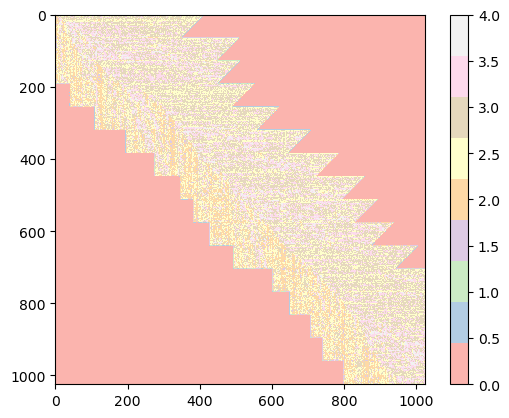

In [22]:
plt.imshow(Trace_2x[:, :], cmap='Pastel1')
plt.colorbar()
plt.show()

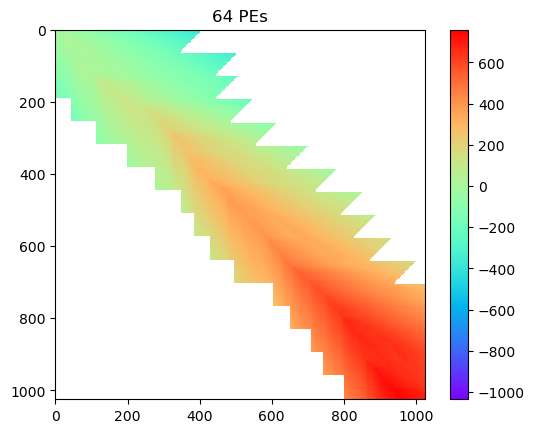

Max score: 759.0 Position: (999, 941)
Local Max: 759.0 Position: (999, 941)


In [23]:
plt.imshow(V[:, :], cmap='rainbow')
plt.colorbar()
plt.title(f'{num_PE} PEs')
plt.show()
print('Max score:', V_max, f'Position: {x_max, y_max}')
print('Local Max:', V_max_local, f'Position: {x_max_local, y_max_local}')

In [24]:
f = open(f'./verilog/test_data/align_{seed}.txt', 'w')
f2 = open('align_xy.txt', 'w')

seq_1 = ''
seq_2 = ''
result = ''
# which matirx are we tracking now
target_matrix = 'T'

# Trace cases
dir_list = [0,0,0,0,0,0,0,0,0,0,0,0]

t = 0

x, y = x_max_local, y_max_local
while(x != 0) and (y != 0):
    t += 1
    f2.write(f"{x} {y} T:{Trace[x][y]} D:{Trace_D[x][y]} I:{Trace_I[x][y]}\n")
    if target_matrix == 'T':
        # print('T', Trace[x][y], x, y, gene_1[x-1], gene_2[y-1])
        f.write(f"{Trace[x][y]}\n")
        if Trace[x][y] == 1:
            seq_1 = gene_1[x-1] + seq_1
            seq_2 = gene_2[y-1] + seq_2
            if gene_1[x-1] == gene_2[y-1]:
                result = '|' + result
            else:
                result = ' ' + result
            x, y = x-1, y-1
        # if direction = top, move to Trace_D
        elif Trace[x][y] == 2:
            if Trace_D[x][y] == 0:
                target_matrix = 'D'
            seq_1 = gene_1[x-1] + seq_1
            seq_2 = '-' + seq_2
            result = ' ' + result
            x, y = x-1, y
        # if direction = left, move to Trace_I
        elif Trace[x][y] == 3:
            if Trace_I[x][y] == 0:
                target_matrix = 'I'
            seq_1 = '-' + seq_1
            seq_2 = gene_2[y-1] + seq_2
            result = ' ' + result
            x, y = x, y-1
    elif target_matrix == 'D':
        # print('D', Trace_D[x][y], x, y)
        # move to Trace if reach gap origin
        f.write("2\n")
        if Trace_D[x][y] == 1:
            target_matrix = 'T'
        seq_1 = gene_1[x-1] + seq_1
        seq_2 = '-' + seq_2
        result = ' ' + result
        x, y = x-1, y
    elif target_matrix == 'I':
        # print('I', Trace_I[x][y], x, y)
        # move to Trace if reach gap origin
        f.write("3\n")
        if Trace_I[x][y] == 1:
            target_matrix = 'T'
        seq_1 = '-' + seq_1
        seq_2 = gene_2[y-1] + seq_2
        result = ' ' + result
        x, y = x, y-1
    # count direction type
    index = (Trace[x,y] - 1)*4 + Trace_I[x,y]*2 + Trace_D[x,y]
    dir_list[int(index)] += 1

parts = len(seq_1)//width + 1
for i in range(parts):
    print(seq_1[i*width:min(i*width+width, len(seq_1))])
    print(result[i*width:min(i*width+width, len(result))])
    print(seq_2[i*width:min(i*width+width, len(seq_2))])
    print('')

print(seq_1 == seq_1_ans)
print(seq_2 == seq_2_ans)
print(f'length: {len(seq_1)}')
print(dir_list)
print(f"time: {t}")
f.close()
f2.close()

CCGTA-------ATGCCTTTCCCTAACAGAGTTTTTCGAACTCGTGTTGTCGAGCGACGG
|||||        ||||||||||| ||                      ||| |      
CCGTAGCCGTGGGTGCCTTTCCCTTAC----------------------TCGGG------

AATTAGATCAGTTAAATGGCAGAAAA--------------CTGGCAGGGCTTTTAGTCGT
      |||  |||| |   ||||||              | ||  ||  |   |||| |
-----AATCGATTAAGT-ATAGAAAACGCTTTTGTTGGTCCGGGTGGGATTCGCAGTCTT

GGGATGATCAGTGGGTAAAGGTGGCGCGGGGTAACGCGCGCTAAGG--------------
||   |    |||   ||||  ||||||||||||||||||||||||              
GGTGCGTCTCGTG---AAAGTGGGCGCGGGGTAACGCGCGCTAAGGTCTGAATTCTGGCA

--------CTCAGC----------TGCAACGCGGAGCTGGTGTGTTATCCAT-TCATGGC
        || |||           |||  ||| | ||      |||| ||| | | | |
TCGACGCACTGAGCGTTTTGCTCGCGCATTGCGCAACTTAACGATTATGCATATGACGAC

AGACAAC--------------TAATACGCA---TAAGCGTAGCCAACCGCATTA--GCGT
 |||| |              |||||||||   |||||||||||||| ||||||   |||
TGACAGCTCGCCAATCTAAATTAATACGCACACTAAGCGTAGCCAACGGCATTATGTCGT

ATG---AACAAAATA---ATGCGAGTTGGGCGTACATACAGTTATAGTGTTTACCGATCT
||    ||||||||    |

In [25]:
f = open(f'./verilog/test_data/align_{seed}.txt', 'w')

# With 2 step diagonal
Trace = Trace_2x

seq_1 = ''
seq_2 = ''
result = ''
# which matirx are we tracking now
target_matrix = 'T'

# Trace cases
dir_list = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]

t = 0

x, y = x_max_local, y_max_local
while(x != 0) and (y != 0):
    t += 1
    if target_matrix == 'T':
        # print('T', Trace[x][y], x, y, gene_1[x-1], gene_2[y-1])
        f.write(f"{Trace[x][y] % 4}\n")
        if Trace[x][y] == 1:
            seq_1 = gene_1[x-1] + seq_1
            seq_2 = gene_2[y-1] + seq_2
            if gene_1[x-1] == gene_2[y-1]:
                result = '|' + result
            else:
                result = ' ' + result
            x, y = x-1, y-1
        # if direction = top, move to Trace_D
        elif Trace[x][y] == 2:
            if Trace_D[x][y] == 0:
                target_matrix = 'D'
            seq_1 = gene_1[x-1] + seq_1
            seq_2 = '-' + seq_2
            result = ' ' + result
            x, y = x-1, y
        # if direction = left, move to Trace_I
        elif Trace[x][y] == 3:
            if Trace_I[x][y] == 0:
                target_matrix = 'I'
            seq_1 = '-' + seq_1
            seq_2 = gene_2[y-1] + seq_2
            result = ' ' + result
            x, y = x, y-1
        elif Trace[x][y] == 4:
            seq_1 = gene_1[x-2] + gene_1[x-1] + seq_1
            seq_2 = gene_2[y-2] + gene_2[y-1] + seq_2
            if gene_1[x-1] == gene_2[y-1]:
                result = '|' + result
            else:
                result = ' ' + result
            if gene_1[x-2] == gene_2[y-2]:
                result = '|' + result
            else:
                result = ' ' + result
            x, y = x-2, y-2
    elif target_matrix == 'D':
        # print('D', Trace_D[x][y], x, y)
        # move to Trace if reach gap origin
        f.write("2\n")
        if Trace_D[x][y] == 1:
            target_matrix = 'T'
        seq_1 = gene_1[x-1] + seq_1
        seq_2 = '-' + seq_2
        result = ' ' + result
        x, y = x-1, y
    elif target_matrix == 'I':
        # print('I', Trace_I[x][y], x, y)
        # move to Trace if reach gap origin
        f.write("3\n")
        if Trace_I[x][y] == 1:
            target_matrix = 'T'
        seq_1 = '-' + seq_1
        seq_2 = gene_2[y-1] + seq_2
        result = ' ' + result
        x, y = x, y-1
    # count direction type
    index = (Trace[x,y] - 1)*4 + Trace_I[x,y]*2 + Trace_D[x,y]
    dir_list[int(index)] += 1

parts = len(seq_1)//width + 1
for i in range(parts):
    print(seq_1[i*width:min(i*width+width, len(seq_1))])
    print(result[i*width:min(i*width+width, len(result))])
    print(seq_2[i*width:min(i*width+width, len(seq_2))])
    print('')

print(seq_1 == seq_1_ans)
print(seq_2 == seq_2_ans)
print(f'length: {len(seq_1)}')
print(dir_list)
print(f"time: {t}")
f.close()

CCGTA-------ATGCCTTTCCCTAACAGAGTTTTTCGAACTCGTGTTGTCGAGCGACGG
|||||        ||||||||||| ||                      ||| |      
CCGTAGCCGTGGGTGCCTTTCCCTTAC----------------------TCGGG------

AATTAGATCAGTTAAATGGCAGAAAA--------------CTGGCAGGGCTTTTAGTCGT
      |||  |||| |   ||||||              | ||  ||  |   |||| |
-----AATCGATTAAGT-ATAGAAAACGCTTTTGTTGGTCCGGGTGGGATTCGCAGTCTT

GGGATGATCAGTGGGTAAAGGTGGCGCGGGGTAACGCGCGCTAAGG--------------
||   |    |||   ||||  ||||||||||||||||||||||||              
GGTGCGTCTCGTG---AAAGTGGGCGCGGGGTAACGCGCGCTAAGGTCTGAATTCTGGCA

--------CTCAGC----------TGCAACGCGGAGCTGGTGTGTTATCCAT-TCATGGC
        || |||           |||  ||| | ||      |||| ||| | | | |
TCGACGCACTGAGCGTTTTGCTCGCGCATTGCGCAACTTAACGATTATGCATATGACGAC

AGACAAC--------------TAATACGCA---TAAGCGTAGCCAACCGCATTA--GCGT
 |||| |              |||||||||   |||||||||||||| ||||||   |||
TGACAGCTCGCCAATCTAAATTAATACGCACACTAAGCGTAGCCAACGGCATTATGTCGT

ATG---AACAAAATA---ATGCGAGTTGGGCGTACATACAGTTATAGTGTTTACCGATCT
||    ||||||||    |

In [26]:
f1 = open(f'./verilog/test_data/gene_1_array_{seed}.txt', 'w')
f2 = open(f'./verilog/test_data/gene_2_array_{seed}.txt', 'w')
d = {'A':0, 'C':1, 'G':2, 'T':3}

for i in range(tile_size):
    f1.write(f'{d[gene_1[i]]}\n')
    f2.write(f'{d[gene_2[i]]}\n')

f1.close()
f2.close()